# Conformity Analysis
Must be performed for PM 2.5 area of Pierce County. The plot below shows the geographic extent of the area. This is used to summarize running emissions. Start emissions are calcualted for the entire county since this is the smallest level of data available. 

In [22]:
import geopandas as gpd

In [65]:
def read_from_sde(connection_string, feature_class_name, version,
                  crs={'init': 'epsg:2285'}, is_table = False):
    """
    Returns the specified feature class as a geodataframe from ElmerGeo.
    
    Parameters
    ----------
    connection_string : SQL connection string that is read by geopandas 
                        read_sql function
    
    feature_class_name: the name of the featureclass in PSRC's ElmerGeo 
                        Geodatabase
    
    cs: cordinate system
    """


    engine = sqlalchemy.create_engine(connection_string)
    con=engine.connect()
    #con.execute("sde.set_current_version {0}".format(version))
    if is_table:
        gdf=pd.read_sql('select * from %s' % 
                   (feature_class_name), con=con)
        con.close()

    else:
        df=pd.read_sql('select *, Shape.STAsText() as geometry from %s' % 
                   (feature_class_name), con=con)
        con.close()

        df['geometry'] = df['geometry'].apply(wkt.loads)
        gdf=gpd.GeoDataFrame(df, geometry='geometry')
        gdf.crs = crs
        cols = [col for col in gdf.columns if col not in 
                ['Shape', 'GDB_GEOMATTR_DATA', 'SDE_STATE_ID']]
        gdf = gdf[cols]
    
    return gdf


In [25]:
gdf_pm25 = gpd.read_file(r'X:\Trans\TIP\AIRQUAL\Conformity\pm25_harn.shp')

<AxesSubplot:>

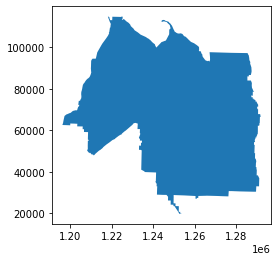

In [28]:
gdf_pm25.plot()

In [32]:
# Load network shapefile to intersect with conformity areas
gdf_network = gpd.read_file(r'../../../inputs/scenario/networks/shapefiles/AM/AM_edges.shp')

In [46]:
# gdf_network.plot()

In [37]:
gdf_intersect = gpd.overlay(gdf_network, gdf_pm25, how="intersection")

C:\Users\Modeller\Anaconda3\envs\summary\lib\site-packages\ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:2285
Right CRS: PROJCS["NAD83 / Washington North (ftUS)",GEOGCS["N ...

  """Entry point for launching an IPython kernel.


<AxesSubplot:>

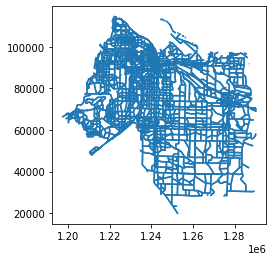

In [38]:
gdf_intersect.plot()

In [39]:
# Join this to network_df to get total volumes
network_df = pd.read_csv(r'../../../outputs/network/network_results.csv')

In [70]:
# Intersect with TAZs to get TAZ list for intrazonal trips
# taz_df = pd.read_csv()
# Load  tract geographies from ElmerGeo
connection_string = 'mssql+pyodbc://AWS-PROD-SQL\Sockeye/ElmerGeo?driver=SQL Server?Trusted_Connection=yes'
crs = {'init' : 'EPSG:2285'}
version = "'DBO.Default'"
gdf_taz2010 = read_from_sde(connection_string, 'taz2010', version, crs=crs, is_table=False)

In [40]:
gdf_taz2010

Index(['direction', 'i', 'j', 'length', 'modes', 'type', 'lanes', 'vdf', 'ul1',
       'ul2', 'ul3', 'toll1', 'toll2', 'toll3', 'trkc1', 'trkc2', 'trkc3',
       'PSRCEdgeID', 'FacilityTy', 'Processing', 'projRteID', 'CountID',
       'CountyID', 'CorridorID', 'is_managed', 'bkfac', 'id', 'weight',
       'upslp', 'Id', 'geometry'],
      dtype='object')

In [41]:
network_df.columns

Index(['@bkfac', '@bkwt', '@bveh', '@bvol', '@corridorid', '@countid',
       '@countyid', '@dveh', '@facilitytype', '@heavy_truck', '@hov2_inc1',
       '@hov2_inc2', '@hov2_inc3', '@hov3_inc1', '@hov3_inc2', '@hov3_inc3',
       '@hveh', '@is_managed', '@medium_truck', '@mveh', '@ovol', '@rdly',
       '@sov_inc1', '@sov_inc2', '@sov_inc3', '@tnc_inc1', '@tnc_inc2',
       '@tnc_inc3', '@toll1', '@toll2', '@toll3', '@trkc1', '@trkc2', '@trkc3',
       '@trnv', '@trnv3', '@tveh', '@upslp', '@vht', '@vmt',
       'additional_volume', 'auto_time', 'auto_volume', 'aux_transit_volume',
       'data1', 'data2', 'data3', 'length', 'num_lanes', 'type',
       'volume_delay_func', 'modes', 'i_node', 'j_node', 'ij', 'speed',
       'congestion_index', 'congestion_category', 'tod'],
      dtype='object')

In [42]:
network_pm25 = gdf_intersect.merge(network_df, left_on='id', right_on='ij')

In [48]:
def grams_to_tons(value):
	""" Convert grams to tons."""

	value = value/453.592
	value = value/2000

	return value

def calculate_interzonal_vmt():
    """ Calcualte inter-zonal running emission rates from network outputs
    """

    # List of vehicle types to include in results; note that bus is included here but not for intrazonals
    vehicle_type_list = ['sov','hov2','hov3','bus','medium_truck','heavy_truck']

    # Load link-level volumes by time of day and network county flags
    df = pd.read_csv(r'outputs/network/network_results.csv')

    # Apply county names
    county_id_lookup = {
	    33: 'king',
	    35: 'kitsap',
	    53: 'pierce',
	    61: 'snohomish'
    }

    df['geog_name'] = df['@countyid'].map(county_id_lookup)

    # Remove links with facility type = 0 from the calculation
    df['facility_type'] = df['data3']    # Rename for human readability
    df = df[df['facility_type'] > 0]

    # Calculate VMT by bus, SOV, HOV2, HOV3+, medium truck, heavy truck
    df['sov_vol'] = df['@sov_inc1']+df['@sov_inc2']+df['@sov_inc3']
    df['sov_vmt'] = df['sov_vol']*df['length']
    df['hov2_vol'] = df['@hov2_inc1']+df['@hov2_inc2']+df['@hov2_inc3']
    df['hov2_vmt'] = df['hov2_vol']*df['length']
    df['hov3_vol'] = df['@hov3_inc1']+df['@hov3_inc2']+df['@hov3_inc3']
    df['hov3_vmt'] = df['hov3_vol']*df['length']
    df['bus_vmt'] = df['@bveh']*df['length']
    df['medium_truck_vmt'] = df['@mveh']*df['length']
    df['heavy_truck_vmt'] = df['@hveh']*df['length']

    # Convert TOD periods into hours used in emission rate files
    df['hourId'] = df['tod'].map(tod_lookup).astype('int')

    # Calculate congested speed to separate time-of-day link results into speed bins
    df['congested_speed'] = (df['length']/df['auto_time'])*60
    df['avgspeedbinId'] = pd.cut(df['congested_speed'], speed_bins, labels=speed_bins_labels).astype('int')

    # Relate soundcast facility types to emission rate definitions (e.g., minor arterial, freeway)
    df['roadtypeId'] = df["facility_type"].map(fac_type_lookup).astype('int')

    # Take total across columns where distinct emission rate are available
    # This calculates total VMT, by vehicle type (e.g., HOV3 VMT for hour 8, freeway, King County, 55-59 mph)
    join_cols = ['avgspeedbinId','roadtypeId','hourId','geog_name']
    df = df.groupby(join_cols).sum()
    df = df[['sov_vmt','hov2_vmt','hov3_vmt','bus_vmt','medium_truck_vmt','heavy_truck_vmt']]
    df = df.reset_index()

    # Write this file for calculation with different emission rates
    df.to_csv(r'outputs/emissions/interzonal_vmt_grouped.csv', index=False)

    return df

def finalize_emissions(df, col_suffix=""):
    """ 
    Compute PM10 and PM2.5 totals, sort index by pollutant value, and pollutant name.
    For total columns add col_suffix (e.g., col_suffix='intrazonal_tons')
    """

    pm10 = df[df['pollutantID'].isin([100,106,107])].groupby('veh_type').sum().reset_index()
    pm10['pollutantID'] = 'PM10'
    pm25 = df[df['pollutantID'].isin([110,116,117])].groupby('veh_type').sum().reset_index()
    pm25['pollutantID'] = 'PM25'
    df = df.append(pm10)
    df = df.append(pm25)

    return df

def calculate_interzonal_emissions(df, df_rates):
    """ Calculate link emissions using rates unique to speed, road type, hour, county, and vehicle type. """

    df.rename(columns={'geog_name':'county', 'avgspeedbinId': 'avgSpeedBinID', 'roadtypeId': 'roadTypeID', 'hourId': 'hourID'}, inplace=True)

    # Calculate total VMT by vehicle group
    df['light'] = df['sov_vmt']+df['hov2_vmt']+df['hov3_vmt']
    df['medium'] = df['medium_truck_vmt']
    df['heavy'] = df['heavy_truck_vmt']
    # What about buses??
    df.drop(['sov_vmt','hov2_vmt','hov3_vmt','medium_truck_vmt','heavy_truck_vmt','bus_vmt'], inplace=True, axis=1)

    # Melt to pivot vmt by vehicle type columns as rows
    df = pd.melt(df, id_vars=['avgSpeedBinID','roadTypeID','hourID','county'], var_name='veh_type', value_name='vmt')

    df = pd.merge(df, df_rates, on=['avgSpeedBinID','roadTypeID','hourID','county','veh_type'], how='left', left_index=False)
    # Calculate total grams of emission 
    df['grams_tot'] = df['grams_per_mile']*df['vmt']
    df['tons_tot'] = grams_to_tons(df['grams_tot'])

#     df.to_csv(r'outputs\emissions\interzonal_emissions.csv', index=False)

    return df

def calculate_intrazonal_vmt():

    df_iz = pd.read_csv(r'outputs/network/iz_vol.csv')

    # Map each zone to county
    county_df = pd.read_sql('SELECT * FROM taz_geography', con=conn)
    df_iz = pd.merge(df_iz, county_df, how='left', on='taz')

    # Sum up SOV, HOV2, and HOV3 volumes across user classes 1, 2, and 3 by time of day
    # Calcualte VMT for these trips too; rename truck volumes for clarity
    for tod in tod_lookup.keys():
        df_iz['sov_'+tod+'_vol'] = df_iz['sov_inc1_'+tod]+df_iz['sov_inc2_'+tod]+df_iz['sov_inc3_'+tod]
        df_iz['hov2_'+tod+'_vol'] = df_iz['hov2_inc1_'+tod]+df_iz['hov2_inc2_'+tod]+df_iz['hov2_inc3_'+tod]
        df_iz['hov3_'+tod+'_vol'] = df_iz['hov3_inc1_'+tod]+df_iz['hov3_inc2_'+tod]+df_iz['hov3_inc3_'+tod]
        df_iz['mediumtruck_'+tod+'_vol'] = df_iz['medium_truck_'+tod]
        df_iz['heavytruck_'+tod+'_vol'] = df_iz['heavy_truck_'+tod]

        # Calculate VMT as intrazonal distance times volumes 
        df_iz['sov_'+tod+'_vmt'] = df_iz['sov_'+tod+'_vol']*df_iz['izdist']
        df_iz['hov2_'+tod+'_vmt'] = df_iz['hov2_'+tod+'_vol']*df_iz['izdist']
        df_iz['hov3_'+tod+'_vmt'] = df_iz['hov3_'+tod+'_vol']*df_iz['izdist']
        df_iz['mediumtruck_'+tod+'_vmt'] = df_iz['mediumtruck_'+tod+'_vol']*df_iz['izdist']
        df_iz['heavytruck_'+tod+'_vmt'] = df_iz['heavytruck_'+tod+'_vol']*df_iz['izdist']

    # Group totals by vehicle type, time-of-day, and county
    df = df_iz.groupby('geog_name').sum().T
    df.reset_index(inplace=True)
    df = df[df['index'].apply(lambda row: 'vmt' in row)]
    df.columns = ['index','King','Kitsap','Pierce','Snohomish']

    # Calculate total VMT by time of day and vehicle type
    # Ugly dataframe reformatting to unstack data
    df['tod'] = df['index'].apply(lambda row: row.split('_')[1])
    df['vehicle_type'] = df['index'].apply(lambda row: row.split('_')[0])
    df.drop('index', axis=1,inplace=True)
    df.index = df[['tod','vehicle_type']]
    df.drop(['tod','vehicle_type'],axis=1,inplace=True)
    df = pd.DataFrame(df.unstack()).reset_index()
    df['tod'] = df['level_1'].apply(lambda row: row[0])
    df['vehicle_type'] = df['level_1'].apply(lambda row: row[1])
    df.drop('level_1', axis=1, inplace=True)
    df.columns = ['geog_name','VMT','tod','vehicle_type']

    # Use hourly periods from emission rate files
    df['hourId'] = df['tod'].map(tod_lookup).astype('int')

    # Export this file for use with other rate calculations
    # Includes total VMT for each group for which rates are available
    df.to_csv(r'outputs/emissions/intrazonal_vmt_grouped.csv', index=False)

    return df

def calculate_intrazonal_emissions(df_running_rates, output_dir):
    """ Summarize intrazonal emissions by vehicle type. """

    df_intra = pd.read_csv(r'outputs/emissions/intrazonal_vmt_grouped.csv')
    df_intra.rename(columns={'vehicle_type':'veh_type', 'VMT': 'vmt', 'hourId': 'hourID', 'geog_name': 'county'},inplace=True)
    df_intra.drop('tod', axis=1, inplace=True)
    df_intra['county'] = df_intra['county'].apply(lambda row: row.lower())

    df_intra_light = df_intra[df_intra['veh_type'].isin(['sov','hov2','hov3'])]
    df_intra_light = df_intra_light.groupby(['county','hourID']).sum()[['vmt']].reset_index()
    df_intra_light.loc[:,'veh_type'] = 'light'

    df_intra_medium = df_intra[df_intra['veh_type'] == 'mediumtruck']
    df_intra_medium.loc[:,'veh_type'] = 'medium'
    df_intra_heavy = df_intra[df_intra['veh_type'] == 'heavytruck']
    df_intra_heavy.loc[:,'veh_type'] = 'heavy'

    df_intra = df_intra_light.append(df_intra_medium)
    df_intra = df_intra.append(df_intra_heavy)

    # For intrazonals, assume standard speed bin and roadway type for all intrazonal trips
    speedbin = 4
    roadtype = 5

    iz_rates = df_running_rates[(df_running_rates['avgSpeedBinID'] == speedbin) &
                        (df_running_rates['roadTypeID'] == roadtype)]

    df_intra = pd.merge(df_intra, iz_rates, on=['hourID','county','veh_type'], how='left', left_index=False)

    # Calculate total grams of emission 
    df_intra['grams_tot'] = df_intra['grams_per_mile']*df_intra['vmt']
    df_intra['tons_tot'] = grams_to_tons(df_intra['grams_tot'])

    # Write raw output to file
    # 	df_intra.to_csv(r'outputs/emissions/intrazonal_emissions.csv', index=False)

    return df_intra

def calculate_start_emissions():
    """ Calculate start emissions based on vehicle population by county and year. """

    df_veh = pd.read_sql('SELECT * FROM vehicle_population WHERE year=='+base_year, con=conn)

    # Scale all vehicles by difference between base year and model total vehicles owned from auto onwership model
    df_hh = pd.read_csv(r'outputs/daysim/_household.tsv', delim_whitespace=True, usecols=['hhvehs'])
    tot_veh = df_hh['hhvehs'].sum()

    # Scale county vehicles by total change
    tot_veh_model_base_year = 3007056
    veh_scale = 1.0+(tot_veh - tot_veh_model_base_year)/tot_veh_model_base_year
    df_veh['vehicles'] = df_veh['vehicles']*veh_scale

    # Join with rates to calculate total emissions
    start_rates_df = pd.read_sql('SELECT * FROM start_emission_rates_by_veh_type WHERE year=='+model_year, con=conn)
    
    # Select winter rates for pollutants other than those listed in summer_list
    df_summer = start_rates_df[start_rates_df['pollutantID'].isin(summer_list)]
    df_summer = df_summer[df_summer['monthID'] == 7]
    df_winter = start_rates_df[~start_rates_df['pollutantID'].isin(summer_list)]
    df_winter = df_winter[df_winter['monthID'] == 1]
    start_rates_df = df_winter.append(df_summer)

    # Sum total emissions across all times of day, by county, for each pollutant
    start_rates_df = start_rates_df.groupby(['pollutantID','county','veh_type']).sum()[['ratePerVehicle']].reset_index()
    
    df = pd.merge(df_veh, start_rates_df, left_on=['type','county'],right_on=['veh_type','county'])
    df['start_grams'] = df['vehicles']*df['ratePerVehicle'] 
    df['start_tons'] = grams_to_tons(df['start_grams'])
    df = df.groupby(['pollutantID','veh_type','county']).sum().reset_index()

#     df.to_csv(r'outputs/emissions/start_emissions.csv', index=False)

    return df

In [63]:
# df_iz = pd.read_csv(r'../../../outputs/network/iz_vol.csv')


,taz,izdist,sov_inc1_5to6,hov2_inc1_5to6,hov3_inc1_5to6,sov_inc2_5to6,hov2_inc2_5to6,hov3_inc2_5to6,sov_inc3_5to6,hov2_inc3_5to6,...,hov2_inc2_20to5,hov3_inc2_20to5,sov_inc3_20to5,hov2_inc3_20to5,hov3_inc3_20to5,tnc_inc1_20to5,tnc_inc2_20to5,tnc_inc3_20to5,medium_truck_20to5,heavy_truck_20to5
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,1,2,0,0,0,1,0,0,0,0
2,3,0,0,0,0,0,0,0,2,1,...,3,0,1,3,1,0,0,0,0,0
3,4,0,0,1,0,0,0,0,0,1,...,1,0,2,0,0,0,1,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3865,3904,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3866,3905,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3867,3906,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3868,3907,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
conn = create_engine('sqlite:///inputs/db/soundcast_inputs.db')

# Load running emission rates by vehicle type, for the model year
df_running_rates = pd.read_sql('SELECT * FROM running_emission_rates_by_veh_type WHERE year=='+model_year, con=conn)
df_running_rates.rename(columns={'ratePerDistance': 'grams_per_mile'}, inplace=True)
df_running_rates['year'] = df_running_rates['year'].astype('str')

# Select the month to use for each pollutant; some rates are used for winter or summer depending
# on when the impacts are at a maximum due to temperature.
df_summer = df_running_rates[df_running_rates['pollutantID'].isin(summer_list)]
df_summer = df_summer[df_summer['monthID'] == 7]
df_winter = df_running_rates[~df_running_rates['pollutantID'].isin(summer_list)]
df_winter = df_winter[df_winter['monthID'] == 1]
df_running_rates = df_winter.append(df_summer)

# Group interzonal trips and calculate interzonal emissions
df_interzonal_vmt = calculate_interzonal_vmt()
df_interzonal = calculate_interzonal_emissions(df_interzonal_vmt, df_running_rates)


In [ ]:

# Group intrazonal trips and calculate intrazonal emissions
df_intrazonal_vmt = calculate_intrazonal_vmt()
df_intrazonal = calculate_intrazonal_emissions(df_running_rates, output_dir)

# Calculate start emissions by vehicle type
start_emissions_df = calculate_start_emissions()

# Combine all rates and export as CSV
df_inter_group = df_interzonal.groupby(['pollutantID','veh_type']).sum()[['tons_tot']].reset_index()
df_inter_group.rename(columns={'tons_tot': 'interzonal_tons'}, inplace=True)
df_intra_group = df_intrazonal.groupby(['pollutantID','veh_type']).sum()[['tons_tot']].reset_index()
df_intra_group.rename(columns={'tons_tot': 'intrazonal_tons'}, inplace=True)
df_start_group = start_emissions_df.groupby(['pollutantID','veh_type']).sum()[['start_tons']].reset_index()

summary_df = pd.merge(df_inter_group, df_intra_group)
summary_df = pd.merge(summary_df, df_start_group, how='left')
summary_df = finalize_emissions(summary_df, col_suffix="")
summary_df.loc[~summary_df['pollutantID'].isin(['PM','PM10','PM25']),'pollutantID'] = summary_df[~summary_df['pollutantID'].isin(['PM','PM10','PM25'])]['pollutantID'].astype('int')
summary_df['pollutant_name'] = summary_df['pollutantID'].astype('int', errors='ignore').astype('str').map(pollutant_map)
summary_df['total_daily_tons'] = summary_df['start_tons']+summary_df['interzonal_tons']+summary_df['intrazonal_tons']
summary_df = summary_df[['pollutantID','pollutant_name','veh_type','start_tons','intrazonal_tons','interzonal_tons','total_daily_tons']]
summary_df.to_csv(os.path.join(output_dir,'emissions_summary.csv'),index=False)

In [45]:
interzonal_df

,avgSpeedBinID,roadTypeID,hourID,county,veh_type,vmt,field1,pollutantID,monthID,grams_per_mile,year,grams_tot,tons_tot
0,1,3,5,king,light,1,824,1,1,0,2018,0,0
1,1,3,5,king,light,1,3944,2,1,10,2018,5,0
2,1,3,5,king,light,1,7064,3,1,1,2018,0,0
3,1,3,5,king,light,1,10184,5,1,0,2018,0,0
4,1,3,5,king,light,1,13304,6,1,0,2018,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103615,15,4,20,snohomish,heavy,"5,660",52070,116,1,0,2018,5,0
103616,15,4,20,snohomish,heavy,"5,660",55142,117,1,0,2018,19,0
103617,15,4,20,snohomish,heavy,"5,660",58262,118,1,0,2018,264,0
103618,15,4,20,snohomish,heavy,"5,660",61382,119,1,0,2018,0,0


In [43]:
# Calcualte emissions totals for this network
network_pm25

,direction,i,j,length_x,modes_x,type_x,lanes,vdf,ul1,ul2,...,type_y,volume_delay_func,modes_y,i_node,j_node,ij,speed,congestion_index,congestion_category,tod
0,1,29587,29618,0,ashijtuvbwlp,90,1,5,900,40,...,90,5,vpilajsutwhb,29587,29618,29587-29618,40,1,Light,5to6
1,1,29587,29618,0,ashijtuvbwlp,90,1,5,900,40,...,90,5,ivsjpubwlath,29587,29618,29587-29618,40,1,Light,6to7
2,1,29587,29618,0,ashijtuvbwlp,90,1,5,900,40,...,90,5,ljtuhvbpwisa,29587,29618,29587-29618,39,1,Light,7to8
3,1,29587,29618,0,ashijtuvbwlp,90,1,5,900,40,...,90,5,sjtwpvbliuah,29587,29618,29587-29618,40,1,Light,8to9
4,1,29587,29618,0,ashijtuvbwlp,90,1,5,900,40,...,90,5,twbuvpsiljah,29587,29618,29587-29618,40,1,Light,9to10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154502,1,48365,47141,0,wk,90,1,9,0,3,...,90,9,wk,48365,47141,48365-47141,-21,0,NaN,15to16
154503,1,48365,47141,0,wk,90,1,9,0,3,...,90,9,wk,48365,47141,48365-47141,-21,0,NaN,16to17
154504,1,48365,47141,0,wk,90,1,9,0,3,...,90,9,wk,48365,47141,48365-47141,-21,0,NaN,17to18
154505,1,48365,47141,0,wk,90,1,9,0,3,...,90,9,kw,48365,47141,48365-47141,-21,0,NaN,18to20
